# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry.

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

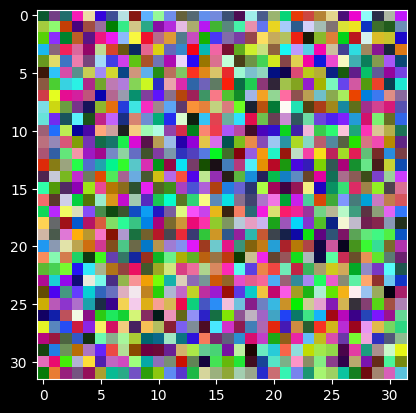

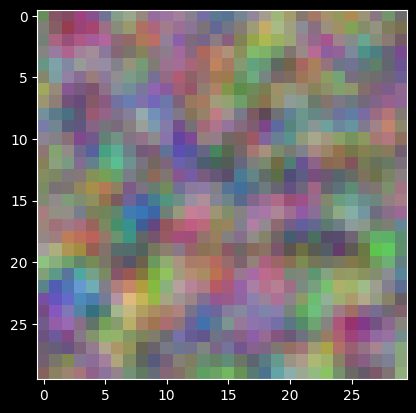

In [12]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


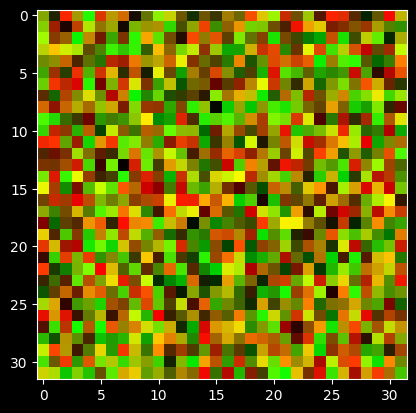

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


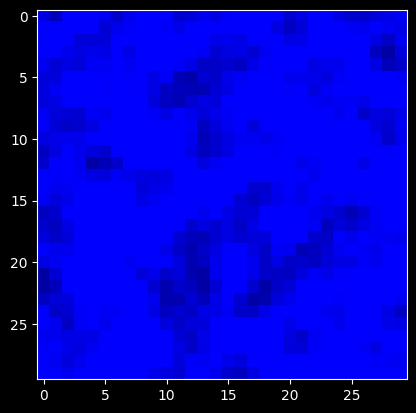

In [14]:
tensor = torch.rand((10,3,32,32))
tensor[:,2] = -7

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

rg_blur_to_b = torch.zeros(3, 3, 3, 3)
rg_blur_to_b[2, 0] = filter  # kanał B otrzymuje uśredniony R i G
rg_blur_to_b[2, 1] = filter  # kanał B otrzymuje uśredniony R i G
blurred = torch.nn.functional.conv2d(tensor,rg_blur_to_b)

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

plt.imshow(blurred[0].permute(1,2,0))
plt.show()

# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

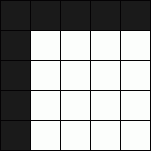

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

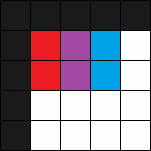
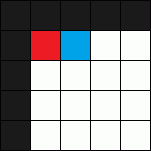


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [15]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2)

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak:

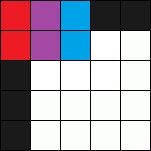

In [16]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1)
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1)
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

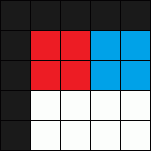


In [17]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

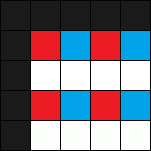

In [18]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

# Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [19]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2,4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling.

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [20]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.to(device))
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.to(device)).sum()
        correct += count_correct(y_pred, y_batch.to(device))
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.to(device))
          loss = loss_fn(y_pred, y_batch.to(device))

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics:
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              )
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

Files already downloaded and verified
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3.

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [21]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", torch.nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1, stride=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool", torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.model.add_module("conv_2", torch.nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, padding=1, stride=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(channels*2*16*16, labels))

  def forward(self, x):
    return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [22]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.to(device)
%timeit cnn_model(torch.zeros(128,3,32,32).to(device))

13.8 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.11 ms ± 66.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [23]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:07<00:00, 217.34it/s]


Epoch 0: train loss = 0.038 (acc: 0.573), validation loss = 0.039 (acc: 0.556)


100%|██████████| 1563/1563 [00:06<00:00, 237.63it/s]


Epoch 1: train loss = 0.032 (acc: 0.649), validation loss = 0.034 (acc: 0.616)


100%|██████████| 1563/1563 [00:06<00:00, 241.80it/s]


Epoch 2: train loss = 0.029 (acc: 0.683), validation loss = 0.032 (acc: 0.634)


100%|██████████| 1563/1563 [00:06<00:00, 227.51it/s]


Epoch 3: train loss = 0.027 (acc: 0.693), validation loss = 0.032 (acc: 0.639)


100%|██████████| 1563/1563 [00:06<00:00, 243.60it/s]


Epoch 4: train loss = 0.024 (acc: 0.734), validation loss = 0.031 (acc: 0.661)


# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [24]:
class CNN(torch.nn.Module):
  def __init__(self, input_channels: int, num_classes: int, conv_layers: list, kernel_size: int, use_pooling: bool = True):
    """
    :param input_channels: Liczba kanałów wejściowych (dla obrazów RGB będzie to 3).
    :param num_classes: Liczba klas wyjściowych.
    :param conv_layers: Lista określająca liczbę kanałów na wyjściu każdej warstwy konwolucyjnej.
    :param kernel_size: Rozmiar filtra dla warstw konwolucyjnych (oprócz in_conv, która ma rozmiar 1x1).
    :param use_pooling: Jeśli True, używa MaxPooling do downsamplingu. Jeśli False, używa konwolucji z stride=2.
    """
    super().__init__()

    self.model = nn.Sequential()
    # Warstwa wejściowa - transformacja liczby kanałów bez zmiany rozmiaru przestrzennego
    self.model.add_module("in_conv", nn.Conv2d(input_channels, conv_layers[0], kernel_size=1))
    self.model.add_module("in_relu", nn.ReLU(inplace=True))
    
    # Dodajemy warstwy konwolucyjne i downsampling
    for i in range(1, len(conv_layers)):
      self.model.add_module(f"conv_{i}", nn.Conv2d(conv_layers[i-1], conv_layers[i], kernel_size=kernel_size, padding=kernel_size//2))
      self.model.add_module(f"relu_{i}", nn.ReLU(inplace=True))
      
      if use_pooling:
        self.model.add_module(f"pool_{i}", nn.MaxPool2d(kernel_size=2))
      else:
        self.model.add_module(f"conv_ds_{i}", nn.Conv2d(conv_layers[i], conv_layers[i], kernel_size=kernel_size, stride=2, padding=kernel_size//2))

    # Spłaszczamy wynik do wektora
    self.model.add_module("flatten", nn.Flatten()) 

    # Obliczamy finalny rozmiar cech na wejściu do warstwy liniowej
    final_size = (32 // (2**(len(conv_layers) // 2)))**2 * conv_layers[-1] // 4
    
    self.model.add_module("fc", nn.Linear(final_size, num_classes))

  def forward(self, x):
    x = self.model(x)
    return x

Zweryfikuj działanie implementacji:

In [25]:
dummy_data = torch.zeros(37,3,32,32)
# utwórz CNN z: 15 etykietami wyjściowymi, filtrem 5x5, 3 warstwy conv z liczbą kanałów: 16,32,64, downsampling warstwą konwolucyjną
cnn_model = CNN(input_channels=3, num_classes=15, conv_layers=[16,32,64], kernel_size=5, use_pooling=False)
assert cnn_model(dummy_data).shape == (37,15)
# utwórz CNN: 10 etykiet wyjściowych, filtr 3x3, 4 warstwy conv z liczbą kanałów: 8,16,32,64, downsampling warstwą poolingu
cnn_model = CNN(input_channels=3, num_classes=10, conv_layers=[8,16,32,64], kernel_size=3, use_pooling=True)
assert cnn_model(dummy_data).shape == (37,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.to(device)
%timeit cnn_model(torch.zeros(128,3,32,32).to(device))

21 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.05 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [33]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def train_eval_model(model, train_loader, test_loader, device, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()
    
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'test_loss': [],
        'test_acc': [],
        'test_f1': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_losses, train_preds, train_targets = [], [], []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_targets.extend(y_batch.cpu().numpy())
        
        train_loss = np.mean(train_losses)
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_f1'].append(train_f1)
        
        model.eval()
        with torch.no_grad():
            test_losses, test_preds, test_targets = [], [], []
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                test_losses.append(loss.item())
                test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                test_targets.extend(y_batch.cpu().numpy())
            
            test_loss = np.mean(test_losses)
            test_acc = accuracy_score(test_targets, test_preds)
            test_f1 = f1_score(test_targets, test_preds, average='weighted')
            
            metrics['test_loss'].append(test_loss)
            metrics['test_acc'].append(test_acc)
            metrics['test_f1'].append(test_f1)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')
    
    return metrics

In [43]:
def perform_experiments(device):
    experiments = [
        {'name': 'Filter size: 3x3',   'kernel_size': 3, 'use_pooling': True,  'conv_layers': [16, 32, 64]},
        {'name': 'Filter size: 5x5',   'kernel_size': 5, 'use_pooling': True,  'conv_layers': [16, 32, 64]},
        {'name': 'Max Pooling',        'kernel_size': 3, 'use_pooling': True,  'conv_layers': [16, 32, 64]},
        {'name': 'Conv Downsample',    'kernel_size': 3, 'use_pooling': False, 'conv_layers': [16, 32, 64]},
        {'name': 'Channels: 16,32,64', 'kernel_size': 3, 'use_pooling': True,  'conv_layers': [16, 32, 64]},
        {'name': 'Channels: 32,32,32', 'kernel_size': 3, 'use_pooling': True,  'conv_layers': [32, 32, 32]},
    ]

    results = []

    for exp in experiments:
        print(f"Running experiment: {exp['name']}")
        model = CNN(3, 10, exp['conv_layers'], exp['kernel_size'], exp['use_pooling']).to(device)
        metrics = train_eval_model(model, train_dl, test_dl, device, epochs=20)
        results.append((exp['name'], metrics))
        print(f"Finished experiment: {exp['name']}\n")
    
    return results

results = perform_experiments(device)


Running experiment: Filter size: 3x3
Epoch 1/20, Train Loss: 1.5549, Train Acc: 0.4451, Train F1: 0.4409, Test Loss: 1.2964, Test Acc: 0.5365, Test F1: 0.5292
Epoch 2/20, Train Loss: 1.2241, Train Acc: 0.5688, Train F1: 0.5668, Test Loss: 1.1672, Test Acc: 0.5885, Test F1: 0.5837
Epoch 3/20, Train Loss: 1.0881, Train Acc: 0.6184, Train F1: 0.6171, Test Loss: 1.0551, Test Acc: 0.6298, Test F1: 0.6275
Epoch 4/20, Train Loss: 0.9966, Train Acc: 0.6511, Train F1: 0.6500, Test Loss: 1.0414, Test Acc: 0.6333, Test F1: 0.6286
Epoch 5/20, Train Loss: 0.9239, Train Acc: 0.6785, Train F1: 0.6774, Test Loss: 0.9807, Test Acc: 0.6617, Test F1: 0.6534
Epoch 6/20, Train Loss: 0.8705, Train Acc: 0.6968, Train F1: 0.6961, Test Loss: 0.9924, Test Acc: 0.6538, Test F1: 0.6598
Epoch 7/20, Train Loss: 0.8294, Train Acc: 0.7132, Train F1: 0.7124, Test Loss: 0.9617, Test Acc: 0.6685, Test F1: 0.6616
Epoch 8/20, Train Loss: 0.7966, Train Acc: 0.7227, Train F1: 0.7219, Test Loss: 0.9746, Test Acc: 0.6681, Tes

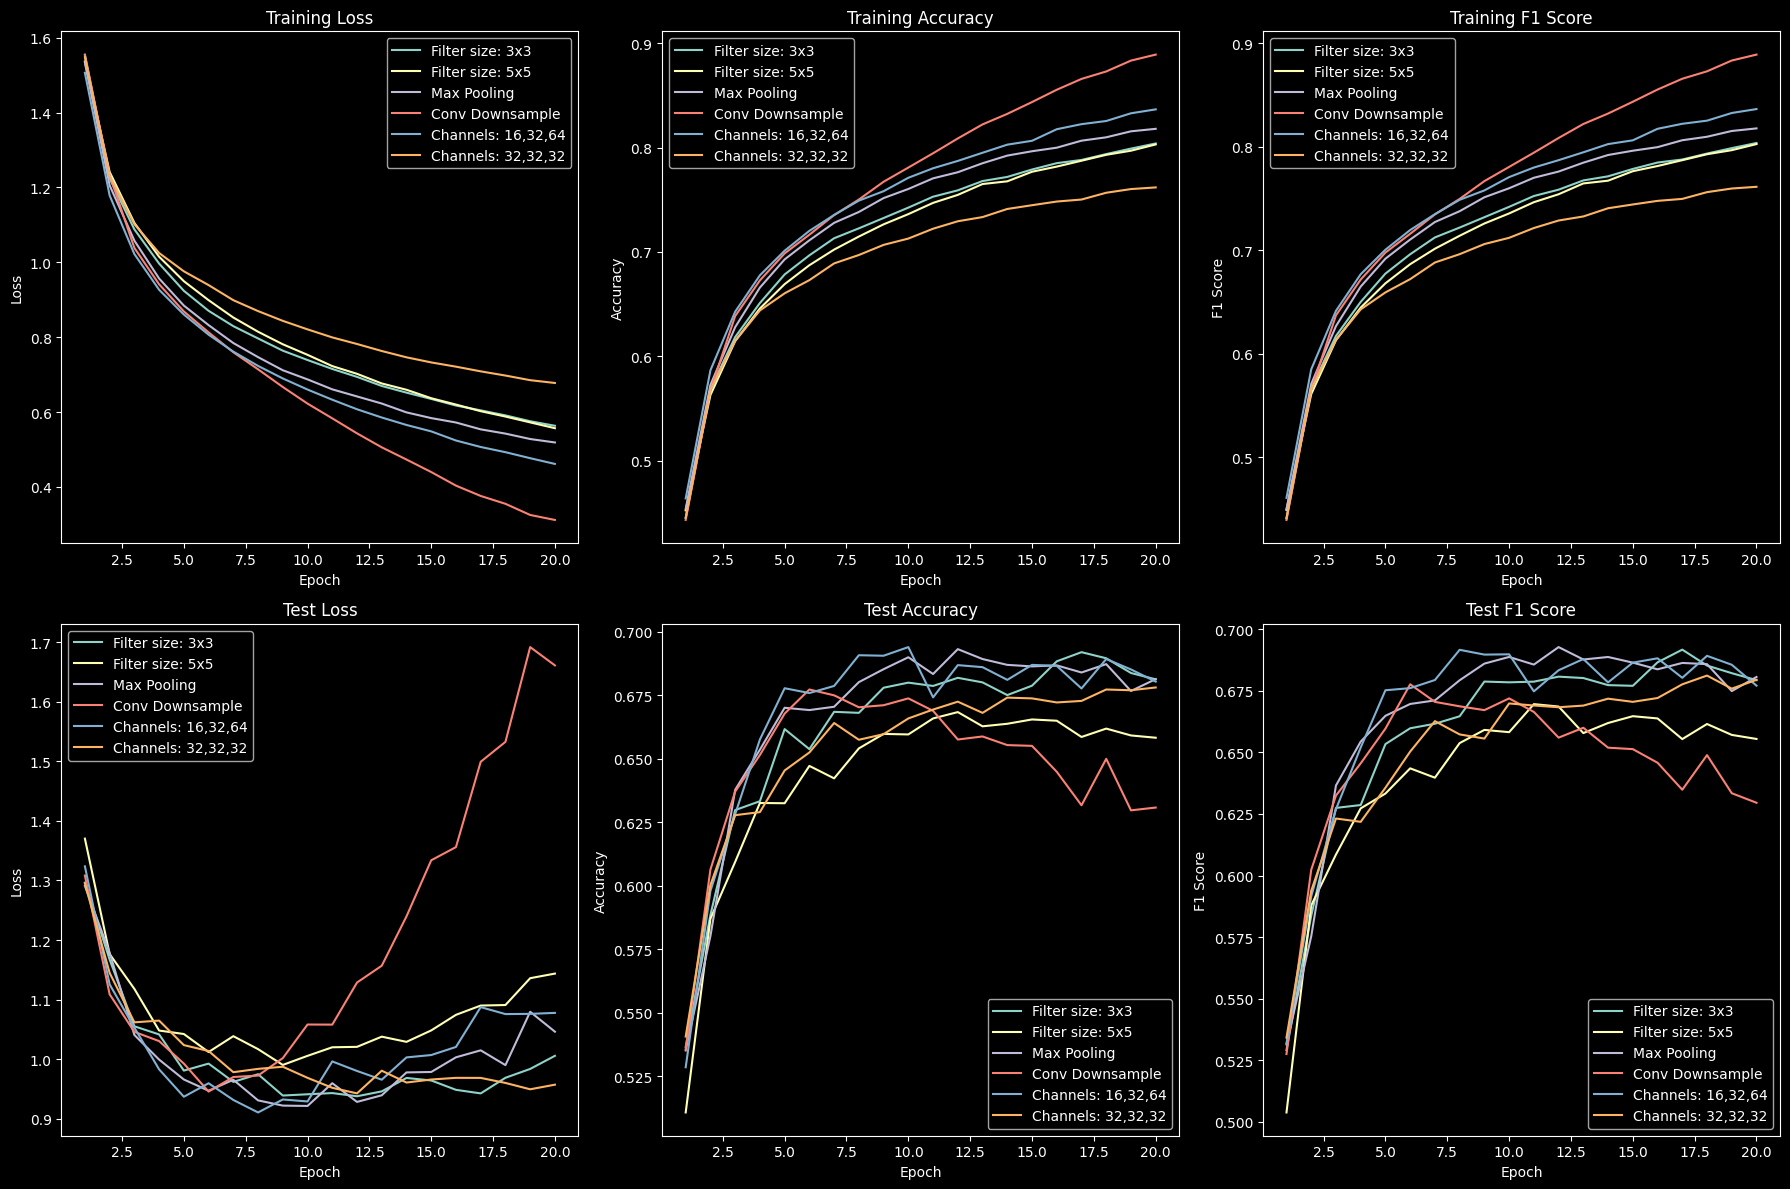

In [44]:
def plot_separate_metrics(results):
    # Ustawienie rozmiaru całej ramki wykresów
    plt.figure(figsize=(18, 12))

    # Subploty dla treningu
    plt.subplot(2, 3, 1)
    for name, metrics in results:
        epochs = range(1, len(metrics['train_loss']) + 1)
        plt.plot(epochs, metrics['train_loss'], label=f'{name}')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    for name, metrics in results:
        epochs = range(1, len(metrics['train_acc']) + 1)
        plt.plot(epochs, metrics['train_acc'], label=f'{name}')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    for name, metrics in results:
        epochs = range(1, len(metrics['train_f1']) + 1)
        plt.plot(epochs, metrics['train_f1'], label=f'{name}')
    plt.title('Training F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Subploty dla testu
    plt.subplot(2, 3, 4)
    for name, metrics in results:
        epochs = range(1, len(metrics['test_loss']) + 1)
        plt.plot(epochs, metrics['test_loss'], label=f'{name}')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 5)
    for name, metrics in results:
        epochs = range(1, len(metrics['test_acc']) + 1)
        plt.plot(epochs, metrics['test_acc'], label=f'{name}')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 6)
    for name, metrics in results:
        epochs = range(1, len(metrics['test_f1']) + 1)
        plt.plot(epochs, metrics['test_f1'], label=f'{name}')
    plt.title('Test F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_separate_metrics(results)